In [2]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from astropy.io import fits

In [3]:
# change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'Greys_r'

# run the %matplotlib magic command to enable inline plotting
# in the current Notebook
%matplotlib inline

In [4]:
zeroes=os.listdir("20181018/Zeroes/")
mars=os.listdir("20181018/Mars/")
comps=os.listdir("20181018/comps/")
darks=os.listdir("20181018/Darks/")
marsNotGarbage=os.listdir("20181018/marsNotGarbage/")

In [71]:
print(zeroes,mars,comps,darks,marsNotGarbage)

['z004.FIT', 'z005.FIT', 'z007.FIT', 'z006.FIT', 'z002.FIT', 'z003.FIT', 'z001.FIT', 'z008.FIT', 'z009.FIT'] ['Mars7Tilt2.FIT', 'Mars10Tilt3.FIT', 'Mars3.FIT', 'Mars2.FIT', 'Mars1.FIT', 'Mars5.FIT', 'Mars4.FIT', 'Mars6.FIT', 'Mars9Tilt3.FIT', 'Mars8Tilt2.FIT'] ['Comp2Ar.FIT', 'Comp1Ar.FIT'] ['d001.FIT', 'd002.FIT', 'd003.FIT'] ['Mars10Tilt3.FIT', 'Mars2.FIT', 'Mars1.FIT', 'Mars4.FIT', 'Mars9Tilt3.FIT']


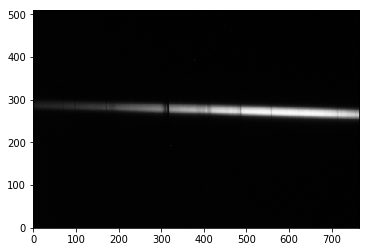

In [72]:
test=fits.open('20181018/Mars/Mars9Tilt3.FIT')[0].data.astype(np.float) 
plt.imshow(test)

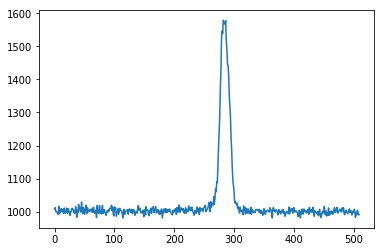

In [63]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(test[:,100])

## Bias correction

In [109]:
nrow,ncol=np.shape(fits.open('20181018/Zeroes/z001.FIT')[0].data.astype(np.float))

alldata=np.ones((len(zeroes),nrow,ncol))

for i in range (0,len(zeroes)):
    sci_fn = '20181018/zeroes/'+zeroes[i]
    sci_hdulist = fits.open(sci_fn)
    alldata[i,:,:] = sci_hdulist[0].data.astype(np.float)

masterbias= np.median(alldata,axis=0)

In [110]:
masterbias

array([[994., 985., 990., ..., 965., 962., 966.],
       [987., 992., 991., ..., 963., 969., 968.],
       [989., 988., 988., ..., 970., 970., 970.],
       ...,
       [986., 989., 988., ..., 964., 971., 965.],
       [984., 988., 985., ..., 964., 967., 974.],
       [993., 993., 986., ..., 971., 968., 973.]])

In [111]:
def unbias(file,directory='Mars/'):
    sci_fn = "20181018/"+directory+file
    out= "CNN/"+file
    sci_hdulist = fits.open(sci_fn)
    biased = sci_hdulist[0].data.astype(np.float)
    biascor= biased-masterbias
    hdu = fits.PrimaryHDU(biascor)
    hdu.writeto(out, overwrite=True)

In [112]:
##'Pythonic' method to unbias all mars spectra
[unbias(file) for file in mars]
[unbias(file,'Darks/') for file in darks]

[None, None, None]

## Dark Correction

In [113]:
nrow,ncol=np.shape(fits.open('CNN/d001.FIT')[0].data.astype(np.float))
alldata=np.ones((len(darks),nrow,ncol))

for i in range (0,len(darks)):
    sci_fn = 'CNN/'+darks[i]
    sci_hdulist = fits.open(sci_fn)
    alldata[i,:,:] = sci_hdulist[0].data.astype(np.float)

masterdark= np.median(alldata,axis=0)

In [117]:
def lightenUp(file,directory='Mars/'):
    sci_fn = "20181018/"+directory+file
    out= "BobRoss/"+file
    sci_hdulist = fits.open(sci_fn)
    darkened = sci_hdulist[0].data.astype(np.float)
    undarkened= darkened-masterdark
    hdu = fits.PrimaryHDU(undarkened)
    hdu.writeto(out, overwrite=True)

In [118]:
##'Pythonic' method to unbias all mars spectra
[lightenUp(file) for file in mars]

[None, None, None, None, None, None, None, None, None, None]

## Sky Background

In [5]:
sci_fn="BobRoss/Mars1.FIT"
sci_hdulist = fits.open(sci_fn)
spec = sci_hdulist[0].data.astype(np.float)

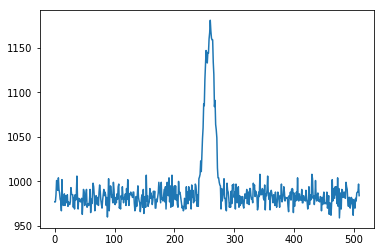

In [19]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(spec[:,382])

## Response

In [60]:
#import astropy fits file handling package and read data array from fits file
from astropy.io import fits
sci_fn = 'MasterFlat.fits'  #this is my median combination of the dome flats
sci_hdulist = fits.open(sci_fn)
masterflat = sci_hdulist[0].data.astype(np.float) # define the data array and list size and data type

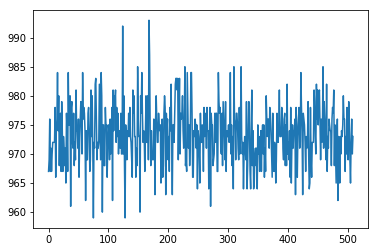

In [64]:
plt.figure()  
plt.plot(masterflat[:,int(ncol/2)])   

In [28]:
MasterFlat=fits.open('MasterFlat.fits')[0].data.astype(np.float)

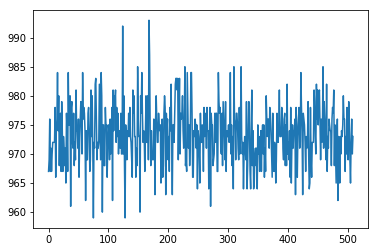

In [59]:
plt.figure()
plt.plot(MasterFlat[:,int(ncol/2)])

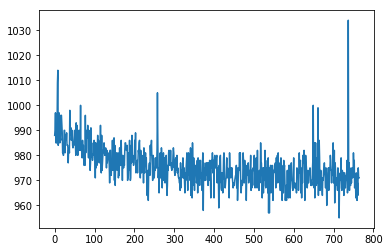

In [39]:
plt.figure()
plt.plot(MasterFlat[int(nrow/2),:])